In [22]:
import theano
import numpy
import os
import gzip
import timeit
import utils
import pickle

import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

try:
    import PIL.Image as Image
except ImportError:
    import Image

# Train a fully connected NN using greedy layer-wise pretraining via RBM with Bernulli hidden units, sample X from full network (previous lecture) (1.0).

### References:
1. https://deeplearning4j.org/restrictedboltzmannmachine

2. http://deeplearning.net/tutorial/rbm.html

3. http://www.cs.toronto.edu/~tijmen/csc321/documents/maddison_rbmtutorial.pdf

** RBM class is shallow, two-layer neural net that constitute the building blocks of deep-belief networks. **

Brief description of RBM class:
1. The parameters of the network can either be initialized by the constructor or can be passed as arguments
2. **propup** - this function propagates the visible units activation upwards to the hidden units
3. **sample_h_given_v** - this function infers state of hidden units given visible units
4. **propdown** - this function propagates the hidden units activation downwards to the visible units
5. **sample_v_given_h** - this function infers state of visible units given hidden units
6. **gibbs_hvh** - this function implements one step of Gibbs sampling
7. **gibbs_vhv** - this function implements one step of Gibbs sampling
8. **get_cost_updates**- this functions implements one step of CD-k or PCD-k
9. **get_pseudo_likelihood_cost** - stochastic approximation to the pseudo-likelihood

In [3]:
class RBM(object):
    """Restricted Boltzmann Machine (RBM)  """
    def __init__(self, input=None, n_visible=784, n_hidden=500, W=None, hbias=None, vbias=None, 
                 numpy_rng=None, theano_rng=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if numpy_rng is None:
            numpy_rng = numpy.random.RandomState(1234)
        if theano_rng is None:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))
        if W is None:
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)
        if hbias is None:
            hbias = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='hbias',
                borrow=True
            )
        if vbias is None:
            vbias = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                name='vbias',
                borrow=True
            )
        self.input = input
        if not input:
            self.input = T.matrix('input')

        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.theano_rng = theano_rng
        self.params = [self.W, self.hbias, self.vbias]

    def propup(self, vis):
        pre_sigmoid_activation = T.dot(vis, self.W) + self.hbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_h_given_v(self, v0_sample):
        pre_sigmoid_h1, h1_mean = self.propup(v0_sample)
        h1_sample = self.theano_rng.binomial(size=h1_mean.shape,
                                             n=1, p=h1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_h1, h1_mean, h1_sample]

    def propdown(self, hid):
        pre_sigmoid_activation = T.dot(hid, self.W.T) + self.vbias
        return [pre_sigmoid_activation, T.nnet.sigmoid(pre_sigmoid_activation)]

    def sample_v_given_h(self, h0_sample):
        pre_sigmoid_v1, v1_mean = self.propdown(h0_sample)
        v1_sample = self.theano_rng.binomial(size=v1_mean.shape,
                                             n=1, p=v1_mean,
                                             dtype=theano.config.floatX)
        return [pre_sigmoid_v1, v1_mean, v1_sample]

    def gibbs_hvh(self, h0_sample):
        pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v1_sample)
        return [pre_sigmoid_v1, v1_mean, v1_sample,
                pre_sigmoid_h1, h1_mean, h1_sample]

    def gibbs_vhv(self, v0_sample):
        pre_sigmoid_h1, h1_mean, h1_sample = self.sample_h_given_v(v0_sample)
        pre_sigmoid_v1, v1_mean, v1_sample = self.sample_v_given_h(h1_sample)
        return [pre_sigmoid_h1, h1_mean, h1_sample,
                pre_sigmoid_v1, v1_mean, v1_sample]

    def free_energy(self, v_sample):
        wx_b = T.dot(v_sample, self.W) + self.hbias
        vbias_term = T.dot(v_sample, self.vbias)
        hidden_term = T.sum(T.log(1 + T.exp(wx_b)), axis=1)
        return -hidden_term - vbias_term

    def get_cost_updates(self, lr=0.1, persistent=None, k=1):
        pre_sigmoid_ph, ph_mean, ph_sample = self.sample_h_given_v(self.input)
        if persistent is None:
            chain_start = ph_sample
        else:
            chain_start = persistent
        (
            [
                pre_sigmoid_nvs,
                nv_means,
                nv_samples,
                pre_sigmoid_nhs,
                nh_means,
                nh_samples
            ],
            updates
        ) = theano.scan(
            self.gibbs_hvh,
            outputs_info=[None, None, None, None, None, chain_start],
            n_steps=k,
            name="gibbs_hvh"
        )
        chain_end = nv_samples[-1]

        cost = T.mean(self.free_energy(self.input)) - T.mean(
            self.free_energy(chain_end))
        gparams = T.grad(cost, self.params, consider_constant=[chain_end])
        for gparam, param in zip(gparams, self.params):
            updates[param] = param - gparam * T.cast(
                lr,
                dtype=theano.config.floatX
            )
        if persistent:
            updates[persistent] = nh_samples[-1]
            monitoring_cost = self.get_pseudo_likelihood_cost(updates)
        else:
            monitoring_cost = self.get_reconstruction_cost(updates,
                                                           pre_sigmoid_nvs[-1])

        return monitoring_cost, updates

    def get_pseudo_likelihood_cost(self, updates):
        bit_i_idx = theano.shared(value=0, name='bit_i_idx')
        xi = T.round(self.input)
        fe_xi = self.free_energy(xi)
        xi_flip = T.set_subtensor(xi[:, bit_i_idx], 1 - xi[:, bit_i_idx])
        fe_xi_flip = self.free_energy(xi_flip)
        cost = T.mean(self.n_visible * T.log(T.nnet.sigmoid(fe_xi_flip - fe_xi)))
        updates[bit_i_idx] = (bit_i_idx + 1) % self.n_visible
        return cost

    def get_reconstruction_cost(self, updates, pre_sigmoid_nv):
        cross_entropy = T.mean(
            T.sum(
                self.input * T.log(T.nnet.sigmoid(pre_sigmoid_nv)) +
                (1 - self.input) * T.log(1 - T.nnet.sigmoid(pre_sigmoid_nv)),
                axis=1
            )
        )
        return cross_entropy

### Main Loop

In [6]:
def test_rbm(learning_rate=0.1, training_epochs=15, dataset='mnist.pkl.gz', batch_size=20,
             n_chains=20, n_samples=10, output_folder='rbm_plots', n_hidden=500):

    datasets = utils.load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()    # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images

    rng = numpy.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    # initialize storage for the persistent chain (state = hidden
    # layer of chain)
    persistent_chain = theano.shared(numpy.zeros((batch_size, n_hidden),
                                                 dtype=theano.config.floatX),
                                     borrow=True)

    # construct the RBM class
    rbm = RBM(input=x, n_visible=28 * 28, n_hidden=n_hidden, numpy_rng=rng, theano_rng=theano_rng)

    # get the cost and the gradient corresponding to one step of CD-15
    cost, updates = rbm.get_cost_updates(lr=learning_rate,
                                         persistent=persistent_chain, k=15)

    #################################
    #     Training the RBM          #
    #################################
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    os.chdir(output_folder)

    train_rbm = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size]
        },
        name='train_rbm'
    )

    plotting_time = 0.
    start_time = timeit.default_timer()

#     go through training epochs
    for epoch in range(training_epochs):

        # go through the training set
        mean_cost = []
        for batch_index in range(n_train_batches):
            mean_cost += [train_rbm(batch_index)]

        print 'Training epoch %d, cost is %f' % (epoch, numpy.mean(mean_cost))

        # Plot filters after each training epoch
        plotting_start = timeit.default_timer()
        # Construct image from the weight matrix
        image = Image.fromarray(
            utils.tile_raster_images(
                X=rbm.W.get_value(borrow=True).T,
                img_shape=(28, 28),
                tile_shape=(10, 10),
                tile_spacing=(1, 1)
            )
        )
        image.save('filters_at_epoch_%i.png' % epoch)
        plotting_stop = timeit.default_timer()
        plotting_time += (plotting_stop - plotting_start)
    
    end_time = timeit.default_timer()
    
    pretraining_time = (end_time - start_time) - plotting_time

    print 'Training took %f minutes' % (pretraining_time / 60.)

    #################################
    #     Sampling from the RBM     #
    #################################
    # find out the number of test samples
    number_of_test_samples = test_set_x.get_value(borrow=True).shape[0]
    test_idx = rng.randint(number_of_test_samples - n_chains)
    persistent_vis_chain = theano.shared(
        numpy.asarray(
            test_set_x.get_value(borrow=True)[test_idx:test_idx + n_chains],
            dtype=theano.config.floatX
        )
    )
    plot_every = 1000
    (
        [
            presig_hids,
            hid_mfs,
            hid_samples,
            presig_vis,
            vis_mfs,
            vis_samples
        ],
        updates
    ) = theano.scan(
        rbm.gibbs_vhv,
        outputs_info=[None, None, None, None, None, persistent_vis_chain],
        n_steps=plot_every,
        name="gibbs_vhv"
    )
    updates.update({persistent_vis_chain: vis_samples[-1]})
    sample_fn = theano.function(
        [],
        [
            vis_mfs[-1],
            vis_samples[-1]
        ],
        updates=updates,
        name='sample_fn'
    )
    image_data = numpy.zeros(
        (29 * n_samples + 1, 29 * n_chains - 1),
        dtype='uint8'
    )
    for idx in range(n_samples):
        vis_mf, vis_sample = sample_fn()
        print ' ... plotting sample %d' % idx
        image_data[29 * idx:29 * idx + 28, :] = utils.tile_raster_images(
            X=vis_mf,
            img_shape=(28, 28),
            tile_shape=(1, n_chains),
            tile_spacing=(1, 1)
        )

    # construct image
    image = Image.fromarray(image_data)
    image.save('samples.png')
    # end-snippet-7
    os.chdir('../')

In [7]:
test_rbm()

... loading data
Training epoch 0, cost is -90.856970
Training epoch 1, cost is -80.449242
Training epoch 2, cost is -74.480474
Training epoch 3, cost is -72.948634
Training epoch 4, cost is -67.891531
Training epoch 5, cost is -63.618820
Training epoch 6, cost is -65.232741
Training epoch 7, cost is -67.101226
Training epoch 8, cost is -68.527130
Training epoch 9, cost is -65.068570
Training epoch 10, cost is -61.502867
Training epoch 11, cost is -61.420024
Training epoch 12, cost is -63.558870
Training epoch 13, cost is -63.932353
Training epoch 14, cost is -62.252069
Training took 23.076791 minutes
 ... plotting sample 0
 ... plotting sample 1
 ... plotting sample 2
 ... plotting sample 3
 ... plotting sample 4
 ... plotting sample 5
 ... plotting sample 6
 ... plotting sample 7
 ... plotting sample 8
 ... plotting sample 9


Once the RBM is trained, we can then use the **gibbs_vhv** function to implement the Gibbs chain required for sampling. We initialize the Gibbs chain starting from test examples (although we could as well pick it from the training set) in order to speed up convergence and avoid problems with random initialization. 

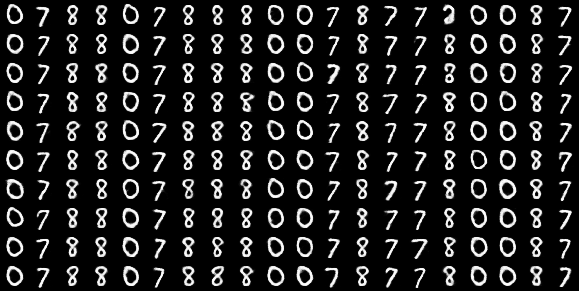

In [10]:
from IPython.display import Image
Image(filename='rbm_plots/samples.png')

### Filters at epoch 0

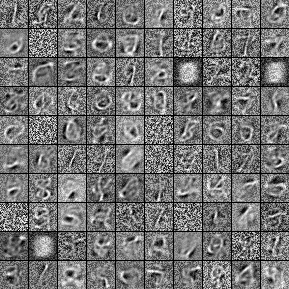

In [12]:
Image(filename='rbm_plots/filters_at_epoch_0.png')

### Filters at epoch 7

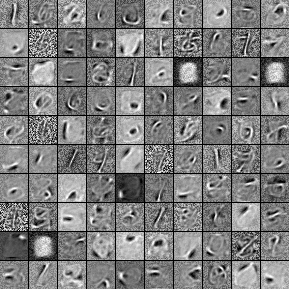

In [21]:
Image(filename='rbm_plots/filters_at_epoch_7.png')

### Filters at epoch 14

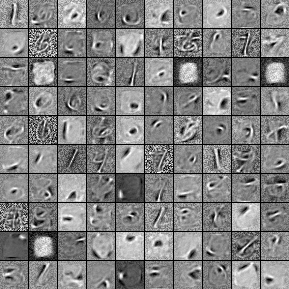

In [16]:
Image(filename='rbm_plots/filters_at_epoch_14.png')

### What have I done here? 

1. Detailed understanding of the topic (70%)
2. Trained model - practical part (20%)
3. Analysis of results (10%)